# 作業目標:
    了解 Padding 的作法
    
    了解 Pooling 的作法

# 作業重點:
    (1) 調整Padding 的設定, 看 Pad 後的結果
    
    (2) 調整Pooling 的設定, 看 Poolin 後的結果

1. 以 Tensorflow 為例

    * 池化

    def max_pool_2x2(x):

        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    * 池化跟卷積的情況有點類似

    * x 是卷積後,有經過非線性啟動後的圖像,

    * ksize 是池化滑動張量

    * ksize 的維度[batch, height, width, channels],跟 x 張量相同

    * strides [1, 2, 2, 1],與上面對應維度的移動步長

    * padding與卷積函數相同,padding='VALID',對原圖像不進行0填充


延伸閱讀:基於Keras的卷積神經網路（CNN）視覺化
* 連結：https://blog.csdn.net/weiwei9363/article/details/79112872

本文整理自[Deep Learning with Python](https://book.douban.com/subject/27038207/)，書本上完整的代碼在 這裡的[5.4節](https://github.com/fchollet/deep-learning-with-python-notebooks)，介紹三種視覺化方法： 

* 卷積核輸出的視覺化(Visualizing intermediate convnet outputs (intermediate activations)，即視覺化卷積核經過啟動之後的結果。能夠看到圖像經過卷積之後結果，幫助理解卷積核的作用
* 卷積核的視覺化(Visualizing convnets filters)，説明我們理解卷積核是如何感受圖像的
* 熱度圖視覺化(Visualizing heatmaps of class activation in an image)，通過熱度圖，瞭解圖像分類問題中圖像哪些部分起到了關鍵作用，同時可以定位圖像中物體的位置。


延伸閱讀: CNN for Image 過程說明

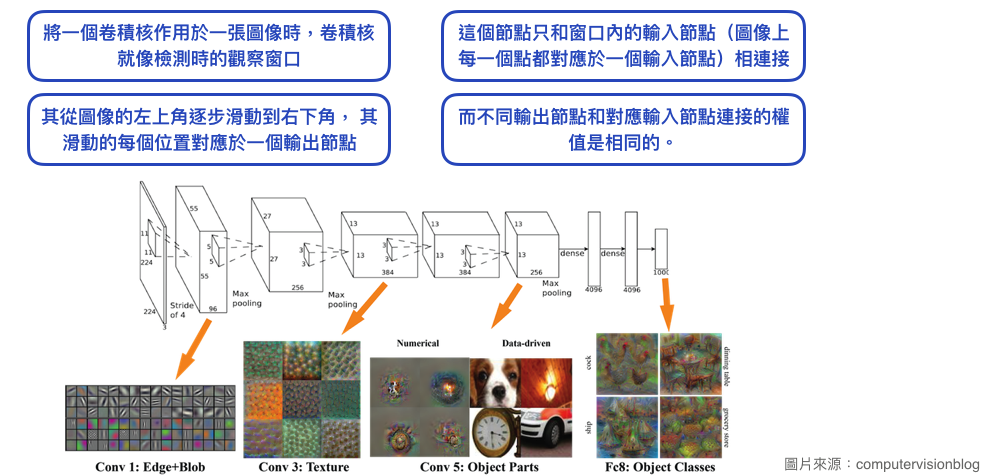

In [7]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

# 繪圖結果直接顯示在Jupyter cell 之內
%matplotlib inline  
plt.rcParams['figure.figsize'] = (5.0, 4.0) #  設定繪圖板的大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# autoreload。可以讓我們不退出IPython就動態修改代碼，在執行代碼前IPython會幫我們自動重載改動的模塊
%load_ext autoreload
%autoreload 2
np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# GRADED FUNCTION: zero_pad
def zero_pad(X, pad):
    """
    對image X 做 zero-padding. 
    參數定義如下:
    X -- python numpy array, 呈現維度 (m, n_H, n_W, n_C), 代表一批 m 個圖像
         n_H: 圖高, n_W: 圖寬, n_C: color channels 數
    pad -- 整數, 加幾圈的 zero padding.
    Returns:
    X_pad -- image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C) 做完zero-padding 的結果
    """
    
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=(0, 0))
  
    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


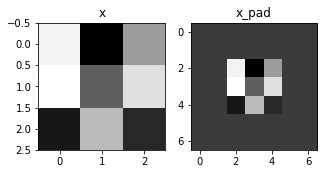

In [9]:
'''
作業修改
'''
np.random.seed(1)

x = np.random.randn(4,3,3,2)
x_pad = zero_pad(x, 2)

print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

In [10]:
# GRADED FUNCTION: pool_forward
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    設計一個前行網路的池化層
    參數定義如下:
    A_prev -- 輸入的numpy 陣列, 維度 (m, n_H_prev, n_W_prev, n_C_prev)
    hparameter 超參數 --  "f" and "stride" 所形成的python 字典
    mode -- 池化的模式: "max" or "average"
    
    返回:
        A -- 輸出的池化層, 維度為 (m, n_H, n_W, n_C) 的 numpy 陣列
        cache -- 可以應用在 backward pass pooling layer 資料, 包含 input and hparameter
    """

    # 檢索尺寸 from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
 
    # 檢索超參數 from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]

    # 定義輸出的dimensions
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev

    # 初始化輸出的 matrix A
    A = np.zeros((m, n_H, n_W, n_C))

    ### 程式起始位置  ###
    for i in range(m): # 訓練樣本的for 迴圈
        for h in range(n_H): # 輸出樣本的for 迴圈, 針對vertical axis
            for w in range(n_W): #  輸出樣本的for 迴圈, 針對 horizontal axis
                for c in range (n_C): #  輸出樣本的for 迴圈, 針對channels

                     # 找出特徵圖的寬度跟高度四個點
                    vert_start = h * stride
                    vert_end = h * stride+ f
                    horiz_start = w * stride
                    horiz_end = w * stride + f

                    # 定義第i個訓練示例
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end,c]

                    # 計算輸入data 的池化結果. 使用 if statment 去做分類
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)

                        ### 程式結束  ###
    
    # 儲存輸入的特徵圖跟所設定的超參數, 可以用在 pool_backward()
    cache = (A_prev, hparameters)
    
    # 確認輸出的資料維度
    assert(A.shape == (m, n_H, n_W, n_C))
    return A, cache

In [11]:
'''
作業修改
'''
np.random.seed(1)
A_prev = np.random.randn(2,4,4,2)
hparameters = {"stride" : 2, "f": 3}


A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[1.62434536 1.14472371]]]


 [[[0.30017032 1.6924546 ]]]]

mode = average
A = [[[[ 0.24327527 -0.6477943 ]]]


 [[[-0.45401158 -0.06000156]]]]
